In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_test = pd.read_csv('train.csv', delimiter=',')
train_test_predict = pd.DataFrame(train_test['situacao'])

predict = pd.read_csv('test.csv', delimiter=',')
predict_code = predict['sequencial_candidato']

train_test = train_test.replace(['nao_eleito', 'eleito'], [0, 1])


# Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)

('Class 0:', 6596)
('Class 1:', 1026)
('Proportion:', 6.0, ': 1')


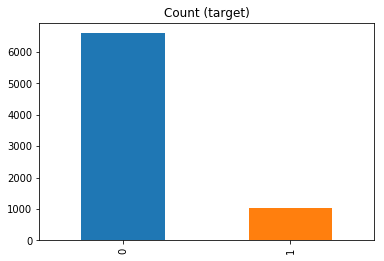

In [3]:
target_count = train_test.situacao.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Como podemos ver no gráfico acima, claramente há um desbalanceamento. Esse é um problema que causa redução da acurácia dos modelos, uma vez que o classificador vai tender para a classe majoritária (a não eleição). 

Para “resolver” o problema do desbalanceamento existem algumas formas, são elas: Undersampling, que consiste em remover algumas instâncias do dataset cuja classe é a majoritária. Oversampling: Pode ser dividido em dois tipos, Random Oversampling e Informative Oversampling, basicamente o que ocorre é a criação instâncias da classe minoritária. 

Synthetic Data Generation: Em palavras simples, em vez de replicar e adicionar as observações da classe minoritária, supera desequilíbrios gerando dados artificiais. É também um tipo de técnica de sobreamostragem.

Nesse exemplo irei "criar" dados da classe minoritária.

In [4]:
train_test.shape

(7622, 24)

In [5]:
# Class count
count_class_0, count_class_1 = train_test.situacao.value_counts()

# Divide by class
df_class_0 = train_test[train_test['situacao'] == 0]
df_class_1 = train_test[train_test['situacao'] == 1]

Random over-sampling:
1    6596
0    6596
Name: situacao, dtype: int64


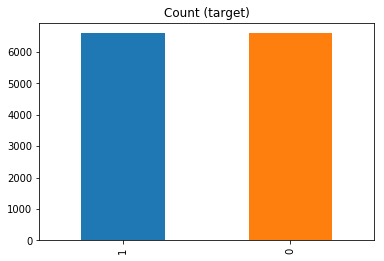

In [6]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.situacao.value_counts())

df_test_over.situacao.value_counts().plot(kind='bar', title='Count (target)');

Como podemos ver no gráfico acima, agora os dados estão balanceados.

In [7]:
# Substituindo os dados pelos dados balanceados
train_test = df_test_over
train_test_predict = pd.DataFrame(train_test['situacao'])

In [8]:
train_test.shape

(13192, 24)

In [9]:
predict.shape

(4592, 23)

In [10]:
# Removendo variáveis 'inúteis'
train_test = train_test.drop(['partido', 'ocupacao' , 'sequencial_candidato', 'nome', 'grau', 'cargo', 'estado_civil', 'situacao'], axis=1)

In [11]:
# Removendo variáveis 'inúteis'
predict = predict.drop(['partido', 'ocupacao' , 'sequencial_candidato', 'nome', 'grau', 'cargo', 'estado_civil'], axis=1)

In [12]:
train_test.shape

(13192, 16)

In [13]:
predict.shape

(4592, 16)

In [14]:
train_test.head()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
0,2006,AP,6,6,16600.00,2766.67,0.0,9000.00,6300.00,1300.00,0.0,14,14,16583.60,1184.54,MASCULINO
1,2006,RO,13,13,22826.00,1755.85,6625.0,15000.00,1000.00,201.00,0.0,24,23,20325.99,846.92,FEMININO
3,2006,MS,6,6,3001.12,500.19,0.0,1150.00,1101.12,750.00,0.0,8,8,3001.12,375.14,MASCULINO
5,2006,AP,8,8,42668.26,5333.53,2250.0,1418.26,0.00,39000.00,0.0,38,37,42668.25,1122.85,MASCULINO
6,2006,PI,6,6,1771.21,295.20,0.0,0.00,0.00,1771.21,0.0,9,9,1771.21,196.80,MASCULINO


In [15]:
predict.head()

,ano,uf,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo
0,2014,AC,3,3,1580.00,526.67,0.00,1500.00,0.00,0.00,80.0,3,3,1580.00,526.67,MASCULINO
1,2014,AC,5,5,3180.00,636.00,0.00,3100.00,0.00,0.00,80.0,6,5,3130.02,521.67,MASCULINO
2,2014,AC,40,38,336793.13,8419.83,1923.07,65700.00,154170.06,115000.00,0.0,145,139,326869.78,2254.27,MASCULINO
3,2014,AC,29,29,156719.32,5404.11,39122.32,68783.84,17000.00,6813.16,25000.0,136,121,241016.07,1772.18,MASCULINO
4,2014,AC,160,146,737073.00,4606.71,10000.00,347073.00,277000.00,78000.00,25000.0,518,354,567401.15,1095.37,MASCULINO


In [16]:
# Normalizando os dados

numeric_feats = train_test.dtypes[train_test.dtypes != "object"].index

skewed_feats = train_test[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train_test[skewed_feats] = np.log1p(train_test[skewed_feats])


In [17]:
# Normalizando os dados

numeric_feats = predict.dtypes[predict.dtypes != "object"].index

skewed_feats = predict[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

predict[skewed_feats] = np.log1p(predict[skewed_feats])

In [18]:
train_test.shape

(13192, 16)

In [19]:
predict.shape

(4592, 16)

In [20]:
# Tratamento das variáveis categóricas.
train_test['sexo'] = pd.Categorical(train_test['sexo'])
train_test['sexo'] = train_test.sexo.cat.codes

In [21]:
# Tratamento das variáveis categóricas.
train_test_predict['situacao'] = pd.Categorical(train_test_predict['situacao'])
train_test_predict['situacao'] = train_test_predict.situacao.cat.codes

In [22]:
# Tratamento das variáveis categóricas.
predict['sexo'] = pd.Categorical(predict['sexo'])
predict['sexo'] = predict.sexo.cat.codes

In [23]:
# Tratamento das variáveis categóricas.
train_test = train_test.drop(['ano'], axis=1)
predict = predict.drop(['ano'], axis=1)

In [24]:
# Tratamento das variáveis categóricas.
columns_categories = ['uf']
data_dummies = pd.get_dummies(pd.DataFrame(train_test[columns_categories]))
train_test = pd.concat([train_test, data_dummies], axis=1, sort=False)
train_test = train_test.drop(columns_categories, axis=1)

In [25]:
# Tratamento das variáveis categóricas.
columns_categories = ['uf']
data_dummies = pd.get_dummies(pd.DataFrame(predict[columns_categories]))
predict = pd.concat([predict, data_dummies], axis=1, sort=False)
predict = predict.drop(columns_categories, axis=1)

In [26]:
train_test.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,0.0,2.708050,...,0,0,0,0,0,0,0,0,0,0
1,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,0.0,3.218876,...,0,0,0,1,0,0,0,0,0,0
3,1.945910,1.945910,8.007074,6.216985,0.000000,7.048386,7.004991,6.621406,0.0,2.197225,...,0,0,0,0,0,0,0,0,0,0
5,2.197225,2.197225,10.661234,8.581956,7.719130,7.257891,0.000000,10.571343,0.0,3.663562,...,0,0,0,0,0,0,0,0,0,0
6,1.945910,1.945910,7.479983,5.691035,0.000000,0.000000,0.000000,7.479983,0.0,2.302585,...,0,0,0,0,0,0,0,0,0,0


In [27]:
predict.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,1.386294,1.386294,7.365813,6.268471,0.000000,7.313887,0.000000,0.000000,4.394449,1.386294,...,0,0,0,0,0,0,0,0,0,0
1,1.791759,1.791759,8.064951,6.456770,0.000000,8.039480,0.000000,0.000000,4.394449,1.945910,...,0,0,0,0,0,0,0,0,0,0
2,3.713572,3.663562,12.727227,9.038464,7.562198,11.092869,11.945818,11.652696,0.000000,4.983607,...,0,0,0,0,0,0,0,0,0,0
3,3.401197,3.401197,11.962218,8.595100,10.574474,11.138739,9.741027,8.826758,10.126671,4.919981,...,0,0,0,0,0,0,0,0,0,0
4,5.081404,4.990433,13.510444,8.435486,9.210440,12.757293,12.531776,11.264477,10.126671,6.251904,...,0,0,0,0,0,0,0,0,0,0


In [28]:
data_predict = predict[:]

In [29]:
# Gerando uma amostra dos dados de treino e teste.
data_train, data_test, target_train, target_test = train_test_split(train_test, train_test_predict, random_state = 8)

In [30]:
data_train.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
1956,0.693147,0.693147,8.517393,8.517393,8.517393,0.000000,0.000000,0.000000,0.000000,2.484907,...,0,0,0,0,0,0,0,0,0,0
3387,1.386294,1.386294,7.952615,6.854703,0.000000,0.000000,0.000000,7.952615,0.000000,2.079442,...,0,0,0,0,0,0,0,0,1,0
1007,4.382027,4.330733,13.785367,9.415999,0.000000,11.377232,13.619491,11.002117,6.908755,6.326149,...,0,0,0,0,0,0,0,0,0,0
4342,3.091042,3.091042,9.975901,6.932311,6.464588,9.144307,9.305741,6.216606,0.000000,3.091042,...,0,0,0,0,0,0,0,0,0,0
127,3.583519,3.433987,10.615456,7.060940,0.000000,10.091667,9.705098,0.000000,5.393628,3.332205,...,0,0,0,0,0,0,0,0,0,0


In [31]:
data_test.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
478,3.091042,3.044522,12.738780,9.694317,0.000000,8.958154,12.685215,9.210440,0.000000,4.499810,...,1,0,0,0,0,0,0,0,0,0
5196,1.098612,1.098612,7.030857,6.338594,7.030857,0.000000,0.000000,0.000000,0.000000,1.098612,...,1,0,0,0,0,0,0,0,0,0
4447,4.110874,3.931826,14.923875,10.829550,13.844196,11.702727,14.388410,8.699681,11.512935,7.883823,...,0,0,0,0,0,0,0,0,0,0
6155,3.891820,3.784190,12.347377,8.476380,8.006701,10.737439,10.126671,11.959584,0.000000,4.955827,...,0,0,0,0,0,1,0,0,0,0
3908,0.693147,0.693147,8.006701,8.006701,0.000000,8.006701,0.000000,0.000000,0.000000,1.791759,...,0,0,0,0,0,0,0,0,0,0


In [32]:
data_train.shape

(9894, 41)

In [33]:
data_test.shape

(3298, 41)

In [34]:
# Definição de funções que irão auxiliar na definição e escolha dos modelos.

def confusion_val(classifier, X_train, Y_train, cv):
    y_pred = cross_val_predict(classifier, X_train, Y_train, cv=cv)
    cm = confusion_matrix(Y_train, y_pred)
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Eleito','N Eleito'], normalize=False, title='Matriz de Confusao')
    plt.show()

In [35]:
# Definição de funções que irão auxiliar na definição e escolha dos modelos.

def report_cv(model, x, y):
    f1 = cross_val_score(model, x, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=3058))
    return(f1)

In [36]:
# Definição de funções que irão auxiliar na definição e escolha dos modelos.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

    return plt

In [37]:
# Definição de funções que irão auxiliar na definição e escolha dos modelos.

def sample_confusion_val(Y_train, y_pred):
    cm = confusion_matrix(Y_train, y_pred)
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Eleito','N Eleito'], normalize=False, title='Matriz de Confusao')
    plt.show()

In [38]:
# Definição de funções que irão auxiliar na definição e escolha dos modelos.

def cross_val(classifier, X_train, Y_train, cv):
    acc = cross_val_score(classifier, X_train, Y_train.round(), cv=cv)
    prec = cross_val_score(classifier, X_train, Y_train, scoring='precision', cv=cv)
    rec = cross_val_score(classifier, X_train, Y_train, scoring='recall', cv=cv)
    f1 = cross_val_score(classifier, X_train, Y_train, scoring='f1', cv=cv)
    roc_auc = cross_val_score(classifier, X_train, Y_train, scoring='roc_auc', cv=cv)
    
    print("Accuracy: %.2f%%" % (np.ma.median(acc) * 100))
    print("Precision: %.2f%%" % (np.ma.median(prec) * 100))
    print("Recall: %.2f%%" % (np.ma.median(rec) * 100))
    print("F-measure: %.2f%%" % (np.ma.median(f1) * 100))
    print("ROC AUC: %.2f%%" % (np.ma.median(roc_auc) * 100))

In [39]:
# Definição de funções que irão auxiliar na definição e escolha dos modelos.

def test_model(model):
    model.fit(data_test, target_test)
    print(metrics.classification_report(target_test, model.predict(data_test), output_dict=True)["macro avg"])

# 2) Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.

## Modelo Linear

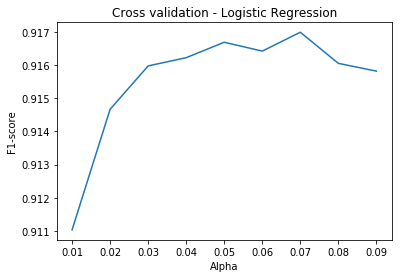

O melhor alpha é 0.07, com F1 = 0.916994597391


In [40]:
from sklearn.linear_model import LogisticRegression
alphas = np.arange(0.01,0.1,0.01).tolist()
cv_logRegression = [report_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=alpha),
                         data_train, 
                         target_train).mean()
                    for alpha in alphas]

cv_logRegression = pd.Series(cv_logRegression, index = alphas)
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

In [41]:
reg_log = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegression.idxmax(), random_state=1)

In [44]:
cross_val(reg_log, data_train, target_train['situacao'], 10)


Accuracy: 91.16%
Precision: 88.89%
Recall: 94.96%
F-measure: 91.58%
ROC AUC: 95.78%


In [45]:
cross_val(reg_log, data_test, target_test['situacao'], 10)

Accuracy: 91.52%
Precision: 88.45%
Recall: 96.03%
F-measure: 91.84%
ROC AUC: 96.01%


## KNN

A melhor quantidade de vizinhos é 21, com F1 = 0.904944546677


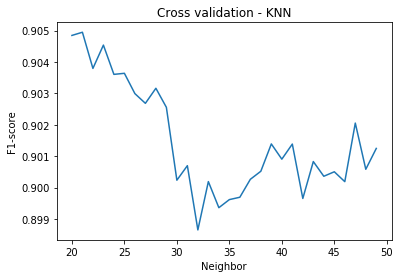

In [46]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(20,50,1).tolist()
cv_knn = [report_cv(KNeighborsClassifier(n_neighbors=neighbor),
               data_train,
               target_train).mean() 
            for neighbor in neighbors]

cv_knn = pd.Series(cv_knn, index = neighbors)
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Neighbor")
plt.ylabel("F1-score")
print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

In [47]:
knn = KNeighborsClassifier(n_neighbors=cv_knn.idxmax())

In [48]:
cross_val(knn, data_train, target_train['situacao'], 10)

Accuracy: 89.74%
Precision: 86.74%
Recall: 94.26%
F-measure: 90.22%
ROC AUC: 95.38%


In [49]:
cross_val(knn, data_test, target_test['situacao'], 10)

Accuracy: 89.36%
Precision: 85.51%
Recall: 93.58%
F-measure: 89.88%
ROC AUC: 94.80%


## Árvore de decisão

A profundidade máxima ideal é 14, com F1 = 0.953643306337


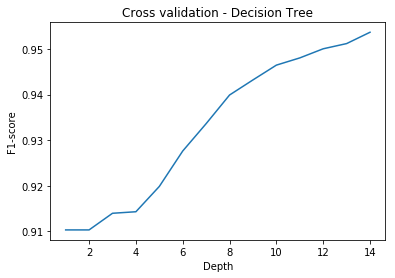

In [50]:
from sklearn.tree import DecisionTreeClassifier
depths = np.arange(1,15,1).tolist()
cv_tree = [report_cv(DecisionTreeClassifier(max_depth = depth),
                data_train,
                target_train).mean() 
            for depth in depths]

cv_tree = pd.Series(cv_tree, index = depths)
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
print("A profundidade máxima ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

In [51]:
tree = DecisionTreeClassifier(max_depth=cv_tree.idxmax())

In [52]:
cross_val(tree, data_train, target_train['situacao'], 10)

Accuracy: 95.15%
Precision: 91.57%
Recall: 99.60%
F-measure: 95.38%
ROC AUC: 96.42%


In [53]:
cross_val(tree, data_test, target_test['situacao'], 10)

Accuracy: 92.58%
Precision: 89.68%
Recall: 96.32%
F-measure: 92.49%
ROC AUC: 92.47%


## Ada Boost 

A quantidade de árvores ideal é 39, com F1 = 0.940638314148


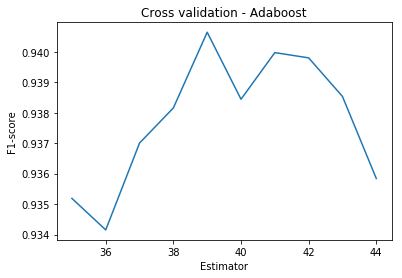

In [54]:
from sklearn.ensemble import AdaBoostClassifier
estimators = np.arange(35,45,1).tolist()
cv_ada =  [report_cv(AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
                data_test,
                target_test).mean() 
            for estimator in estimators]

cv_ada = pd.Series(cv_ada, index = estimators)
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

In [55]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=cv_ada.idxmax())

In [56]:
cross_val(ada, data_train, target_train['situacao'], 10)

Accuracy: 96.66%
Precision: 93.85%
Recall: 99.90%
F-measure: 96.88%
ROC AUC: 99.93%


In [57]:
cross_val(ada, data_test, target_test['situacao'], 10)

Accuracy: 93.94%
Precision: 89.89%
Recall: 98.16%
F-measure: 94.33%
ROC AUC: 98.73%


## Random Forest

A quantidade de árvores ideal é 159, com F1 = 0.936638936583


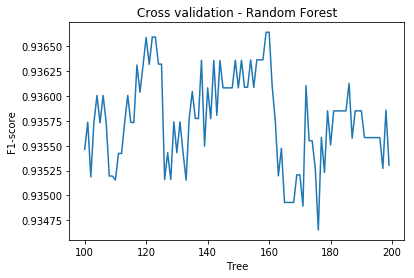

In [58]:
from sklearn.ensemble import RandomForestClassifier
trees = np.arange(100,200,1).tolist()
cv_random_forest = [report_cv(RandomForestClassifier(n_estimators=tree, max_depth=cv_tree.idxmax(), random_state=0),
                         data_test,
                         target_test).mean() 
                    for tree in trees]

cv_random_forest = pd.Series(cv_random_forest, index = trees)
cv_random_forest.plot(title = "Cross validation - Random Forest")
plt.xlabel("Tree")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_random_forest.idxmax(), cv_random_forest.max()))

In [59]:
random_forest = RandomForestClassifier(n_estimators=cv_random_forest.idxmax(), max_depth=cv_tree.idxmax(), 
                                       random_state=10)

In [60]:
cross_val(random_forest, data_train, target_train['situacao'], 10)

Accuracy: 95.35%
Precision: 91.51%
Recall: 100.00%
F-measure: 95.57%
ROC AUC: 99.67%


In [61]:
cross_val(random_forest, data_test, target_test['situacao'], 10)

Accuracy: 93.64%
Precision: 89.26%
Recall: 98.78%
F-measure: 93.90%
ROC AUC: 98.28%


In [ ]:
submission = pd.read_csv("./sample_submission.csv")
m = AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=cv_ada.idxmax())
m.fit(data_train, target_train)
predicts_submission = pd.DataFrame(m.predict(predict))
predicts_submission = predicts_submission.replace([0, 1],['nao_eleito', 'eleito'])
submission["Predicted"] = predicts_submission
submission.to_csv("./my_sample_submission.csv", index = false)